In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing dependencies

In [2]:
!pip install fastText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.5 MB/s 
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
  Created wheel for fastText: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3163180 sha256=2674107dd4af4a86d24df23719bc477ef50dd664248a3bcc1d318945dfb93eae
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fastText


Importing required libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [5]:
import fasttext
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  
ft = fasttext.load_model('cc.en.300.bin')

Pre-processing data

In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/MI/data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/MI/data/test.csv')

In [7]:
y_train = to_categorical(df_train.label.values)
y_test = to_categorical(df_test.label.values)

In [8]:
df_train['text'] = df_train['text'].astype('string')

In [9]:
df_train.isna().sum()

text     2
label    0
dtype: int64

In [10]:
df_train = df_train.dropna()
df_train.isna().sum()

text     0
label    0
dtype: int64

In [11]:
maxi = -1
for i, rev in enumerate(df_train['text']):
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)
print(maxi)

20


In [12]:
#tokenizing the tweet text
tokenizer = Tokenizer()
df_total = pd.concat([df_train['text'], df_test.text], axis = 0)
tokenizer.fit_on_texts(df_total)

In [13]:
max_rev_len = maxi  # max lenght of a word
vocab_size = len(tokenizer.word_index) + 1 # total no of words
embed_dim = 300

In [14]:
print(len(tokenizer.word_index))

10644


In [15]:
#padding the tokenized text
X_train = tokenizer.texts_to_sequences(df_train['text']) #converting texts into some numeric sequences 
X_train_pad = pad_sequences(X_train, maxlen = max_rev_len, padding = 'post') #making the length of all numeric sequences equal 
X_test = tokenizer.texts_to_sequences(df_test.text)
X_test_pad = pad_sequences(X_test, maxlen = max_rev_len, padding = 'post')

In [16]:
# now creating the embedding matrix
embed_matrix = np.zeros(shape = (vocab_size, embed_dim))
for word, i in tokenizer.word_index.items():
  embed_vector = ft.get_word_vector(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the fasttext model
    embed_matrix[i] = embed_vector
embed_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.17441928e-02,  7.39639550e-02, -1.30568799e-02, ...,
         2.37025172e-01,  4.47519124e-04, -4.19306662e-03],
       [ 8.76430497e-02, -4.95901257e-01, -4.98549901e-02, ...,
         5.34850955e-01, -5.58103584e-02, -1.65984333e-02],
       ...,
       [-5.86136058e-03, -5.20238169e-02, -3.51554677e-02, ...,
         5.02261408e-02, -1.76106580e-02, -4.63075191e-02],
       [-7.36382455e-02,  1.09481346e-03,  6.54756743e-03, ...,
         2.95933709e-02,  1.84881873e-03, -5.54246493e-02],
       [ 2.35681795e-02, -1.01697538e-02,  7.46165495e-03, ...,
         7.01421201e-02,  4.00606077e-03, -1.00959511e-02]])

Training the data on the model

In [17]:
#defining the layers in the model
def create_model():
  class_num = 2
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size, output_dim = embed_dim, input_length = max_rev_len, weights = [embed_matrix], trainable = False))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(128, return_sequences = True)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(128, return_sequences = True)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(64, return_sequences = False)))
  model.add(Dense(class_num, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
  return model

In [18]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 300)           3193500   
                                                                 
 dropout (Dropout)           (None, 20, 300)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          439296    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 20, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 256)          394240    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0

In [19]:
history_embedding = model.fit(X_train_pad, y_train, epochs = 10, batch_size = 64, validation_split = 0.1, verbose = 1)

Epoch 1/10
101/101 [==============================] - 47s 332ms/step - loss: 0.6391 - accuracy: 0.6265 - val_loss: 0.7902 - val_accuracy: 0.5049
Epoch 2/10
101/101 [==============================] - 30s 294ms/step - loss: 0.6017 - accuracy: 0.6827 - val_loss: 0.7977 - val_accuracy: 0.5132
Epoch 3/10
101/101 [==============================] - 31s 310ms/step - loss: 0.5830 - accuracy: 0.6978 - val_loss: 0.8281 - val_accuracy: 0.5132
Epoch 4/10
101/101 [==============================] - 29s 292ms/step - loss: 0.5702 - accuracy: 0.7096 - val_loss: 0.8350 - val_accuracy: 0.4979
Epoch 5/10
101/101 [==============================] - 31s 309ms/step - loss: 0.5570 - accuracy: 0.7209 - val_loss: 0.8703 - val_accuracy: 0.5021
Epoch 6/10
101/101 [==============================] - 29s 289ms/step - loss: 0.5444 - accuracy: 0.7316 - val_loss: 0.8566 - val_accuracy: 0.4951
Epoch 7/10
101/101 [==============================] - 31s 307ms/step - loss: 0.5304 - accuracy: 0.7428 - val_loss: 1.0279 - val_ac

Visualizing the training and validation results

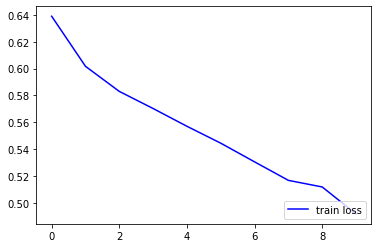

In [20]:
plt.plot(history_embedding.history['loss'], c = 'b', label = 'train loss')
plt.legend(loc = 'lower right')
plt.show()

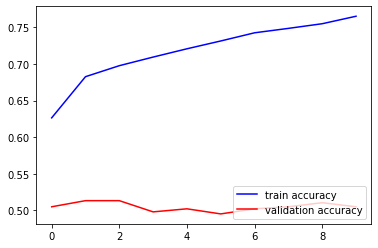

In [21]:
plt.plot(history_embedding.history['accuracy'], c = 'b', label = 'train accuracy')
plt.plot(history_embedding.history['val_accuracy'] , c = 'r', label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.show()

Extracting classification report and confusion matrix

In [22]:
y_pred = np.argmax(model.predict(X_test_pad), axis = 1)
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_true, y_pred))

56/56 [==============================] - 6s 68ms/step
              precision    recall  f1-score   support

           0       0.60      0.76      0.67       851
           1       0.71      0.55      0.62       941

    accuracy                           0.65      1792
   macro avg       0.66      0.65      0.64      1792
weighted avg       0.66      0.65      0.64      1792



In [23]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[643 208]
 [428 513]]


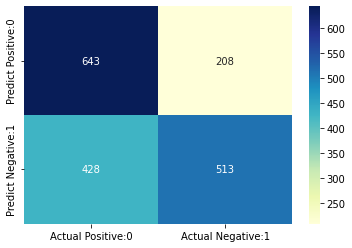

In [24]:
cm_matrix = pd.DataFrame(data = cm, columns = ['Actual Positive:0', 'Actual Negative:1'], index = ['Predict Positive:0', 'Predict Negative:1'])
sns.heatmap(cm_matrix, annot = True, fmt = 'd', cmap = 'YlGnBu')